# Laboratorio 1: Regresión en California

En este laboratorio deben hacer experimentos de regresión con el conjunto de datos "California Housing dataset".

Estudiarán el dataset, harán visualizaciones y seleccionarán atributos relevantes a mano.

Luego, entrenarán y evaluarán diferentes tipos de regresiones, buscando las configuraciones que mejores resultados den.

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from itertools import zip_longest
#Librerías para regresión Lineal - ejercicio 3
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Carga del Conjunto de Datos

Cargamos el conjunto de datos y vemos su contenido.

In [169]:
from sklearn.datasets import fetch_california_housing
X_california, y_california = fetch_california_housing(return_X_y=True, as_frame=True)
california = fetch_california_housing()

In [170]:
california.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [171]:

print(california['DESCR'])  # descripción del dataset
#california['feature_names'] # nombres de los atributos para cada columna de 'data'
#california['data']           # matriz con los datos de entrada (atributos)
#print(california['target']) # vector de valores a predecir

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [172]:
california['data'].shape, california['target'].shape

((20640, 8), (20640,))

## División en Entrenamiento y Evaluación

Dividimos aleatoriamente los datos en 80% para entrenamiento y 20% para evaluación:

Dado que en los gráficos donde exploramos la relación entre los atributos y la variable objetivo notamos que había una acumulación de datos en la variable objetivo en el valor 5 unidades de cientos de miles de dólares, creamos una máscara que filtre esos datos ya que generaba una desproporción. Creemos que esta acumulación se debe a que la encuesta tenia este valor máximo como límite y ese valor fue elegido muchas veces representando valores de la propiedad que en realidad eran mayores. Con la máscara nuestra base de datos queda mejor balanceada y sin ese sesgo.

In [173]:
from sklearn.model_selection import train_test_split
X1, y1 = california['data'], california['target']
mask = y1 < 5
X = X1[mask]
y = y1[mask]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
X_train.shape, X_test.shape

((15718, 8), (3930, 8))

In [174]:
y.shape

(19648,)

In [175]:
y_test.shape

(3930,)

## Ejercicio 1: Descripción de los Datos y la Tarea

Responda las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponibles para hacer la predicción?
4. ¿Qué atributos imagina ud. que serán los más determinantes para la predicción?
5. ¿Qué problemas observa a priori en el conjunto de datos? ¿Observa posibles sesgos, riesgos, dilemas éticos, etc? Piense que los datos pueden ser utilizados para hacer predicciones futuras.

**No hace falta escribir código para responder estas preguntas.**

**1. ¿De qué se trata el conjunto de datos?**

El conjunto de datos "California Housing" contiene información de bloques censales de California tomada del censo de 1990. Cada fila representa un bloque censal y contiene datos sobre características sociodemográficas y geográficas de esos bloques.

**2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?**

La variable objetivo a predecir es MedHouseVal, que representa el valor medio de las casas en cada bloque censal, expresado en cientos de miles de dólares en función de sus atributos.

**3. ¿Qué información (atributos) hay disponibles para hacer la predicción?**

Los atributos disponibles son:

    MedInc: ingreso mediano del grupo de bloques.
    HouseAge: edad mediana de las casas en el grupo de bloques.
    AveRooms: número promedio de habitaciones por hogar.
    AveBedrms: número promedio de dormitorios por hogar.
    Population: población del grupo de bloques.
    AveOccup: número promedio de habitantes por hogar.
    Latitude: latitud del grupo de bloques.
    Longitude: longitud del grupo de bloques.

**4. ¿Qué atributos imagina ud. que serán los más determinantes para la predicción?**

Los atributos que probablemente serán más determinantes son:

    MedInc: Ingreso mediano, ya que está directamente relacionado con el valor de las propiedades.
    HouseAge: Edad de las casas, ya que casas más nuevas o más viejas pueden tener diferentes valores.
    AveRooms: El tamaño y la calidad de las casas pueden influir en el valor.
    Latitude y Longitude: La ubicación geográfica, ya que ciertos lugares pueden ser más caros que otros.

**5. ¿Qué problemas observa a priori en el conjunto de datos? ¿Observa posibles sesgos, riesgos, dilemas éticos, etc?**

    
    Tras un primer análisis encontramos que puede existir algún problema con respecto a los valores máximos de los valores de las unidades habitacionales.
    Sospechamos que en el censo se fijó un valor máximo de u$s 500.000 (5 en unidades de cientos de miles de dólares), esto puede hacer perder referencia para unidades que podrían tener un mayor valor.
    Este mismo problema de "sesgo" por errores en el diseño del set de datos se observa para el promedio de edad de las propiedades, donde el límite es 55 años.
    
    Sesgo Geográfico: La variabilidad de los precios de las casas puede estar sesgada por la geografía y la concentración de ciertos grupos demográficos en áreas específicas.
    Dilemas Éticos: Usar estos datos para predecir valores futuros podría reforzar la desigualdad si se toman decisiones basadas en predicciones que podrían estar sesgadas.
    Representatividad: Los datos son de 1990, por lo que podrían no representar adecuadamente las condiciones actuales del mercado inmobiliario


## Ejercicio 2: Visualización de los Datos

1. Para cada atributo de entrada, haga una gráfica que muestre su relación con la variable objetivo.
2. Estudie las gráficas, identificando **a ojo** los atributos que a su criterio sean los más informativos para la predicción.
3. Para ud., ¿cuáles son esos atributos? Lístelos en orden de importancia.

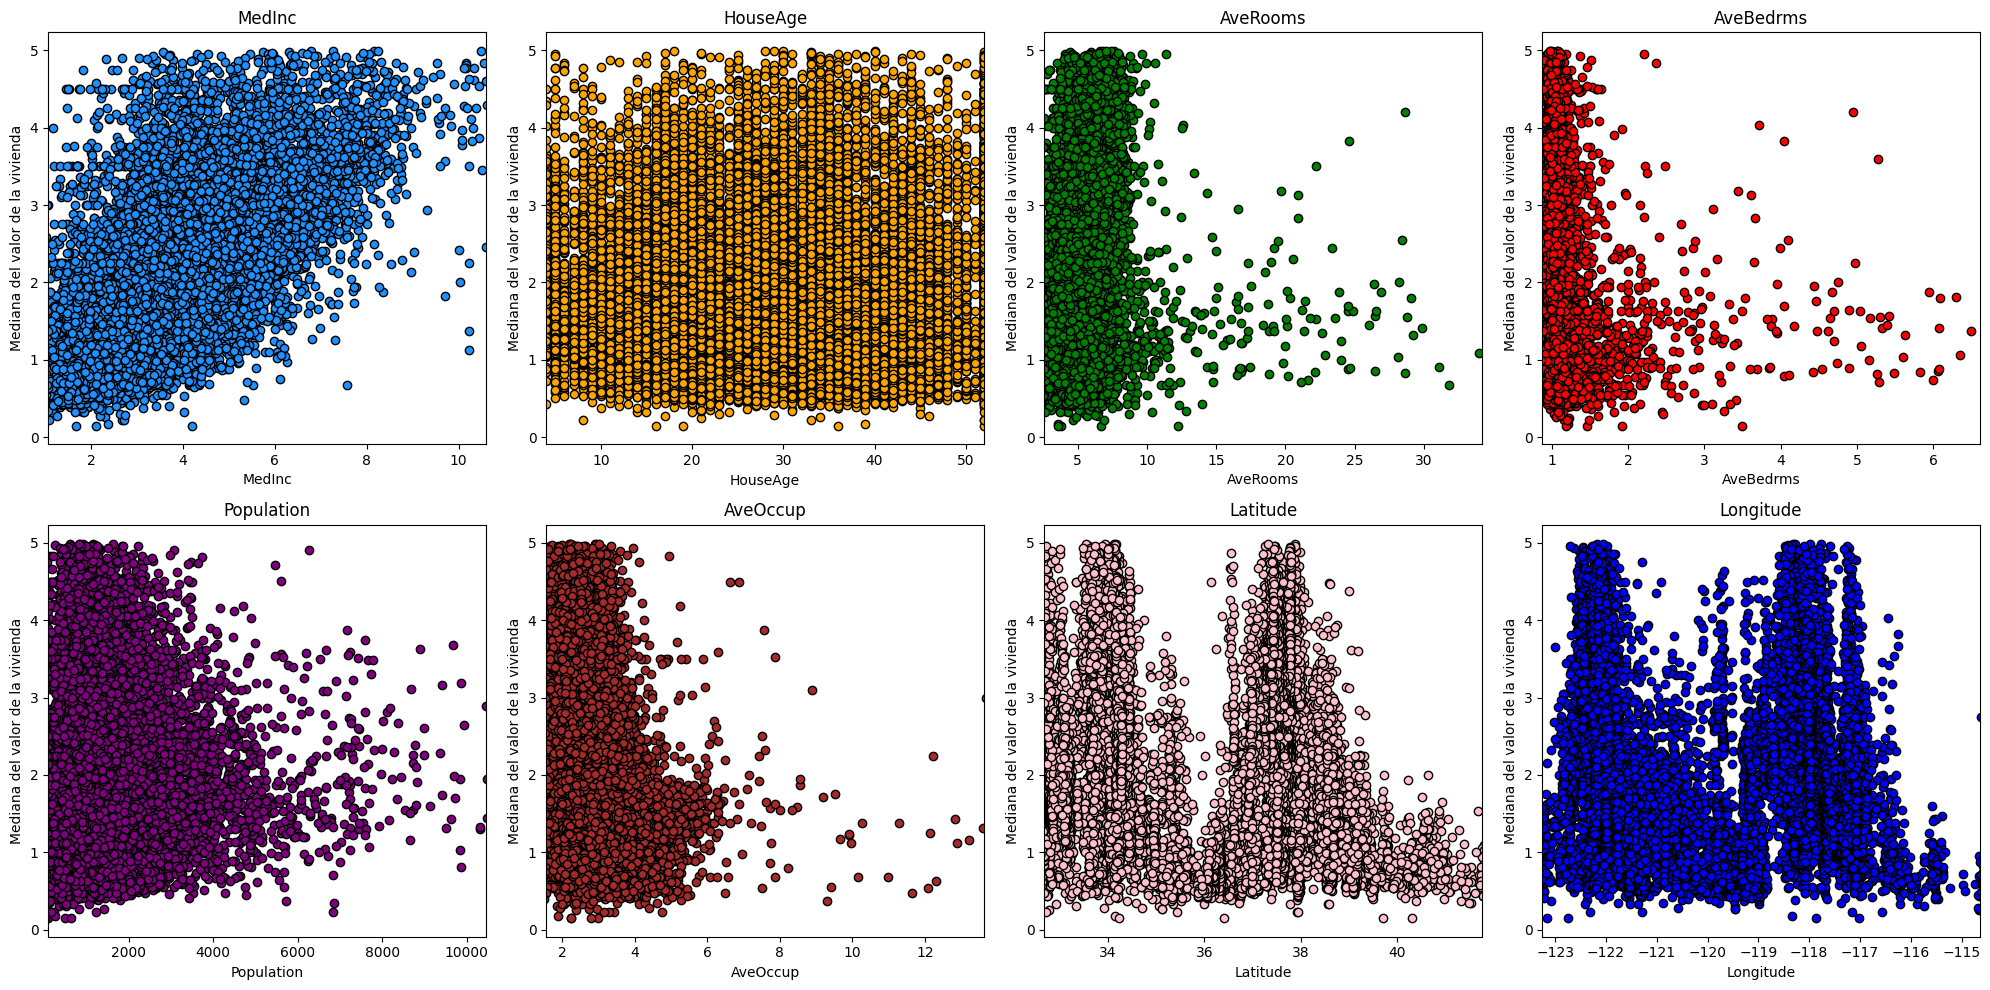

In [176]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()
feature_names=california.feature_names
colores= ["dodgerblue","orange","green","red","purple","brown","pink","blue"]
# Generar gráficos de dispersión para cada característica
for i, (feature, color) in enumerate(zip(feature_names, colores)):
    selector = (np.array(california['feature_names']) == feature)
    feature_data = X[:, selector].flatten()
    q1 = np.percentile(feature_data, 1)
    q3 = np.percentile(feature_data, 99.9)
    #axes[i].scatter(X_california.iloc[:, selector].values, y_california, facecolor="dodgerblue", edgecolor="k", label="datos")
    axes[i].scatter(X[:, selector], y, facecolor=color, edgecolor="k", label="datos")
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Mediana del valor de la vivienda")
    axes[i].set_xlim(q1, q3)

plt.tight_layout()
plt.show()# Crear subplots


**Atributos más informativos**

Consideramos que el atributo HouseAge muestra unda distribución uniforme por lo que consideramos que
no nos brinda una dependencia marcada con respecto al valor medio de la vivienda. Sin embargo, los demás atributos muestras diferentes distribuciones. Al comparar Bedrooms y Rooms, observamos que las distribuciones son medianamente equivalentes por lo que podriamos seleccionar una de ellas.
Notamos que los atributos Room, Bedroom, AveOccup y Population presentan outliers por lo que es necesario
limpiar estos atributos. Esto nos permitirá observar mejor sus distribuciones en funcion del valor medio de la vivienda.

Hay ciertos atributos que presentan tendencias muy marcadas:

-Ingreso promedio: a medida que aumenta el ingreso promedio aumenta el valor de la vivienda.

-Population: se observa distribucion uniforme hasta 4mil personas pero luego el valor de la vivienda disminuye. Esto se lo puede atribuir
a que al aumentar la densidad poblacional estariamos hablando de departamentos y no de casas.

-Latitude y Longitude: Se observan tendencias en el precio según la ubicación de la vivienda. Esto podría estar relacionado a la distribucíon geofráfica de
 "barrios" en la ciudad de california (barrios populares, barrios lujosos).  

Basado en la inspección visual de las gráficas, los atributos más importantes parecen ser:

    MedInc
    Latitude
    Longitude
    Population
    AveRooms


## Ejercicio 3: Regresión Lineal

1. Seleccione **un solo atributo** que considere puede ser el más apropiado.
2. Instancie una regresión lineal de **scikit-learn**, y entrénela usando sólo el atributo seleccionado.
3. Evalúe, calculando error cuadrático medio para los conjuntos de entrenamiento y evaluación.
4. Grafique el modelo resultante, junto con los puntos de entrenamiento y evaluación.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se puede obtener un error en test menor a 50.

Vamos a implementar un modelo de regresión lineal, para ello debemos dividir el data set en un conjunto de datos de entrenamiento y otro conjunto con datos de validación para el atributo MedInc que es el atributo que usaremos para la regresión lineal.

In [177]:
# 1. Resolver acá. Ayuda:
feature = 'MedInc'  # selecciono el atributo 'MedInc'
#selector = california['feature_names'].index(feature)
selector = (np.array(california['feature_names']) ==  feature)
X_train_f = X_train[:, selector]
X_test_f = X_test[:, selector]
X_train_f.shape, X_test_f.shape

((15718, 1), (3930, 1))

In [178]:
#Armamos un data frame para los datos de entrenamiento y otro para los datos de validacion, hacemos esto para hacer una limpieza con cuantiles
Xx = np.array(X_train_f)
Yy = np.array(y_train)
dataset = pd.DataFrame({'Xtrain': Xx[:,0], 'Ytrain': Yy}, columns=['Xtrain', 'Ytrain'])
Xxtest = np.array(X_test_f)
Yytest = np.array(y_test)
dataset_test = pd.DataFrame({'Xtest': Xxtest[:,0], 'Ytest': Yytest}, columns=['Xtest', 'Ytest'])


In [179]:
#Aplicamos la limpieza (solo para el atributo con el que estamos ahciendo la regresión lineal y la respectiva variable target)

Q3_t = dataset["Xtrain"].quantile(.995)
df=dataset[dataset['Xtrain']<Q3_t]
XT=np.array(df.Xtrain)
y_trainc=np.array(df.Ytrain)
X_train_fc = np.zeros((len(XT), 1))
X_train_fc[:,0]=XT

Q3 = dataset_test["Xtest"].quantile(.995)
df_test=dataset_test[dataset_test['Xtest']<Q3]
XT_test=np.array(df_test.Xtest)
y_testc=np.array(df_test.Ytest)
X_test_c = np.zeros((len(XT_test), 1))
X_test_c[:,0]=XT_test

In [180]:
# 2. Instanciar y entrenar acá.
# Instanciación y entrenamiento del modelo
regr = LinearRegression()
regr2 = LinearRegression()
# Entrenar
regr.fit(X_train_f, y_train)
LR_square = regr.score(X_train_f, y_train)
LR_coef = regr.coef_
LR_intercept = regr.intercept_
print("Análisis de Regresion Lineal para la variable:",feature)
print("------------")
print("El valor de R^2 de la correlacion es:", LR_square)
print("El valor de la pendiente es:", LR_coef)
print("El valor de la ordenada al origen es", LR_intercept)
# Pruebo también de entrenar cortando outliers
regr2.fit(X_train_fc, y_trainc)
LR_square2 = regr2.score(X_train_fc, y_trainc)
LR_coef2 = regr2.coef_
LR_intercept2 = regr2.intercept_
print("------------")
print("Análisis de Regresion Lineal para la variable sin outlier:",feature)
print("El valor de R^2 de la correlacion es:", LR_square2)
print("El valor de la pendiente es:", LR_coef2)
print("El valor de la ordenada al origen es", LR_intercept2)

Análisis de Regresion Lineal para la variable: MedInc
------------
El valor de R^2 de la correlacion es: 0.419690297548865
El valor de la pendiente es: [0.39876339]
El valor de la ordenada al origen es 0.45418721656704486
------------
Análisis de Regresion Lineal para la variable sin outlier: MedInc
El valor de R^2 de la correlacion es: 0.41351510051219376
El valor de la pendiente es: [0.40878686]
El valor de la ordenada al origen es 0.420602826028893


In [181]:
# 3. Predecir y evaluar acá.
# Predicción y evaluación con y sin outliers
y_train_pred = regr.predict(X_train_f)
y_test_pred = regr.predict(X_test_f)
y_train_predc = regr.predict(X_train_fc)
y_test_predc = regr.predict(X_test_c)

In [182]:
# Cálculo del error cuadrático medio
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_msec = mean_squared_error(y_trainc, y_train_predc)
test_msec = mean_squared_error(y_testc, y_test_predc)

In [183]:
print(f'Errores Cuadrático Medios (MSE):')
print(f'MSE en entrenamiento: {train_mse}')
print(f'MSE en validación: {test_mse}')
print(f'MSE en entrenamiento sin outlier: {train_msec}')
print(f'MSE en validación sin outlier: {test_msec}')

Errores Cuadrático Medios (MSE):
MSE en entrenamiento: 0.5435363419380601
MSE en validación: 0.5688488710907876
MSE en entrenamiento sin outlier: 0.5377794984738925
MSE en validación sin outlier: 0.5676761009800491


LO que se observa en estos valores (MSE) a la regresión lineal de estos datos no le afectan los outliers.

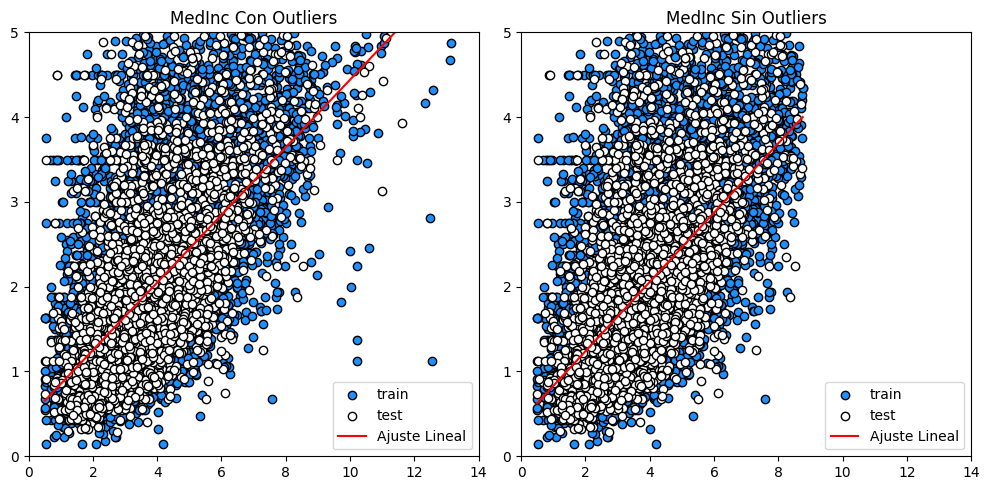

In [184]:
# 4. Graficar acá. Ayuda:
x_start = min(np.min(X_train_f), np.min(X_test_f))
x_end = max(np.max(X_train_f), np.max(X_test_f))
x = np.linspace(x_start, x_end, 200).reshape(-1, 1)
# plt.plot(x, model.predict(x), color="tomato", label="modelo")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Primer subplot
ax1.scatter(X_train_f, y_train, facecolor="dodgerblue", edgecolor="k", label="train")
ax1.scatter(X_test_f, y_test, facecolor="white", edgecolor="k", label="test")
ax1.plot(x, [LR_coef*i+LR_intercept for i in x], color="red", label="Ajuste Lineal")
ax1.set_title(feature + " Con Outliers")
ax1.legend(loc='lower right')



# Segundo subplot
x_startc = min(np.min(X_train_fc), np.min(X_test_c))
x_endc = max(np.max(X_train_fc), np.max(X_test_c))
xc = np.linspace(x_startc, x_endc, 200).reshape(-1, 1)
ax2.scatter(X_train_fc, y_trainc, facecolor="dodgerblue", edgecolor="k", label="train")
ax2.scatter(X_test_c, y_testc, facecolor="white", edgecolor="k", label="test")
ax2.plot(xc, [LR_coef2*i+LR_intercept2 for i in xc], color="red", label="Ajuste Lineal")
ax2.set_title(feature + " Sin Outliers")
ax2.legend(loc='lower right')

ax1.set_xlim(0, 14)
ax2.set_xlim(0, 14)
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)

# Mostrar los gráficos
plt.tight_layout()
plt.show()



5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

Si observamos los errores para los datos de entrenamiento y validación vemos que los mismos son similares tanto para los datos con y sin outliers.

Errores Cuadrático Medios (MSE):

MSE en entrenamiento: 0.5435363419380601

MSE en validación: 0.5688488710907876

MSE en entrenamiento sin outlier: 0.5377794984738925

MSE en validación sin outlier: 0.5676761009800491

Al ser similares los errores de entrenamiento y validación en ambos casos (con y sin outliers) podemos concluir que el modelo funciona de forma similar para ambos conjunto de datos.
Esto garantiza que ambos conjuntos de datos son igual de representativos del conjunto de datos original.

Observando el gráfico, podemos decir que la función elegida para modelar nuestro atributo (MedInc) es
representativa de la distribución de valor medio de la vivienda en función del atributo.

## Ejercicio 4: Regresión Polinomial

En este ejercicio deben entrenar regresiones polinomiales de diferente complejidad, siempre usando **scikit-learn**.

Deben usar **el mismo atributo** seleccionado para el ejercicio anterior.

1. Para varios grados de polinomio, haga lo siguiente:
    1. Instancie y entrene una regresión polinomial.
    2. Prediga y calcule error en entrenamiento y evaluación. Imprima los valores.
    3. Guarde los errores en una lista.
2. Grafique las curvas de error en términos del grado del polinomio.
3. Interprete la curva, identificando el punto en que comienza a haber sobreajuste, si lo hay.
4. Seleccione el modelo que mejor funcione, y grafique el modelo conjuntamente con los puntos.
5. Interprete el resultado, haciendo algún comentario sobre las cualidades del modelo obtenido.

**Observación:** Con algunos atributos se pueden obtener errores en test menores a 40 e incluso a 35.

Utilizando el mismo atributo MedInc realizaremos una regresión polinomial para los casos con y sin outliers, iremos variando el grado del polinomio (hiperparámetro) entre los valores 1-10

In [185]:
# 1. Resolver acá.

from sklearn.pipeline import make_pipeline

degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
train_errors = [] #ire guardando los errores para cada grado de pol
test_errors = [] #ire guardando los errores para cada grado de pol
train_errorsc = []
test_errorsc = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_f, y_train)

    y_train_pred = model.predict(X_train_f)
    y_test_pred = model.predict(X_test_f)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

    #Repito sin outliers
    modelc = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    modelc.fit(X_train_fc, y_trainc)

    y_train_predc = modelc.predict(X_train_fc)
    y_test_predc = modelc.predict(X_test_c)

    train_errorsc.append(mean_squared_error(y_trainc, y_train_predc))
    test_errorsc.append(mean_squared_error(y_testc, y_test_predc))
arr1 = np.array(train_errors)
arr2 = np.array(test_errors)
arr1c = np.array(train_errorsc)
arr2c = np.array(test_errorsc)
# Restando los arreglos
dif_errors = abs(arr1 - arr2)
dif_errorsc = abs(arr1c - arr2c)


In [186]:
for j in range(len(dif_errors)):
  print("diferencia de errores con outliers",dif_errors[j]," ; diferencia de errores sin outliers",dif_errorsc[j])


diferencia de errores con outliers 0.025312529152727525  ; diferencia de errores sin outliers 0.029687429575089075
diferencia de errores con outliers 0.02533727213119341  ; diferencia de errores sin outliers 0.029750233871368326
diferencia de errores con outliers 0.02633611233396871  ; diferencia de errores sin outliers 0.029878411767688684
diferencia de errores con outliers 0.026335831329053594  ; diferencia de errores sin outliers 0.03062848389329631
diferencia de errores con outliers 0.026487960568805535  ; diferencia de errores sin outliers 0.027675412538380684
diferencia de errores con outliers 0.02528918527702395  ; diferencia de errores sin outliers 0.02763582627028449
diferencia de errores con outliers 0.024159238900509195  ; diferencia de errores sin outliers 0.02792524160376031
diferencia de errores con outliers 0.024078610217742824  ; diferencia de errores sin outliers 0.02780796782377315
diferencia de errores con outliers 0.023877699696223553  ; diferencia de errores sin ou

In [187]:
print("menor diferencia entre errores con outliers",dif_errors.min(),"menor diferencia entre errores sin outliers",dif_errorsc.min())

menor diferencia entre errores con outliers 0.023877699696223553 menor diferencia entre errores sin outliers 0.02763582627028449


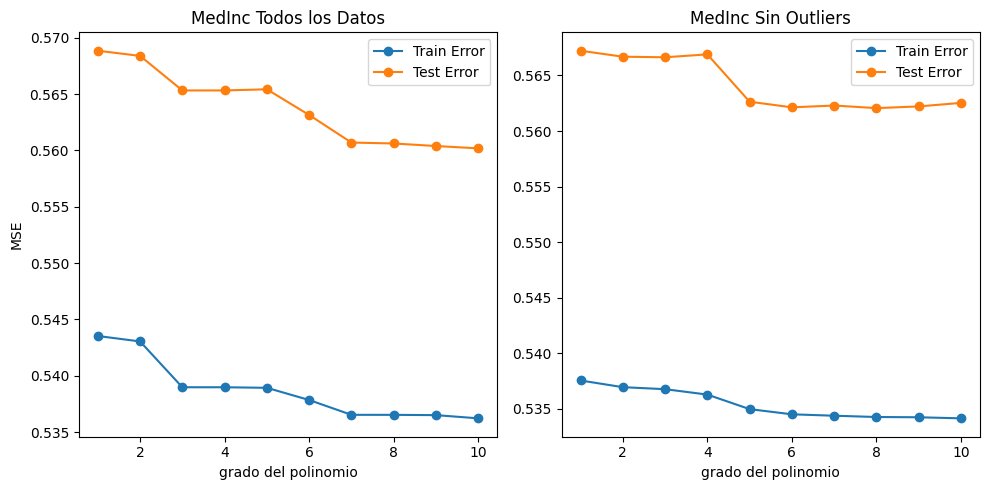

In [188]:
# 2. Graficar curvas de error acá.

# Gráfico de errores

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Primer subplot
ax1.plot(degrees, train_errors, label="Train Error", marker='o')
ax1.plot(degrees, test_errors, label="Test Error", marker='o')
ax1.set_title(feature + " Todos los Datos")
ax1.legend()
ax1.set_xlabel('grado del polinomio')
ax1.set_ylabel('MSE')
# Segundo subplot
ax2.plot(degrees, train_errorsc, label="Train Error", marker='o')
ax2.plot(degrees, test_errorsc, label="Test Error", marker='o')
ax2.set_title(feature + " Sin Outliers")
ax2.set_xlabel('grado del polinomio')
ax2.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()


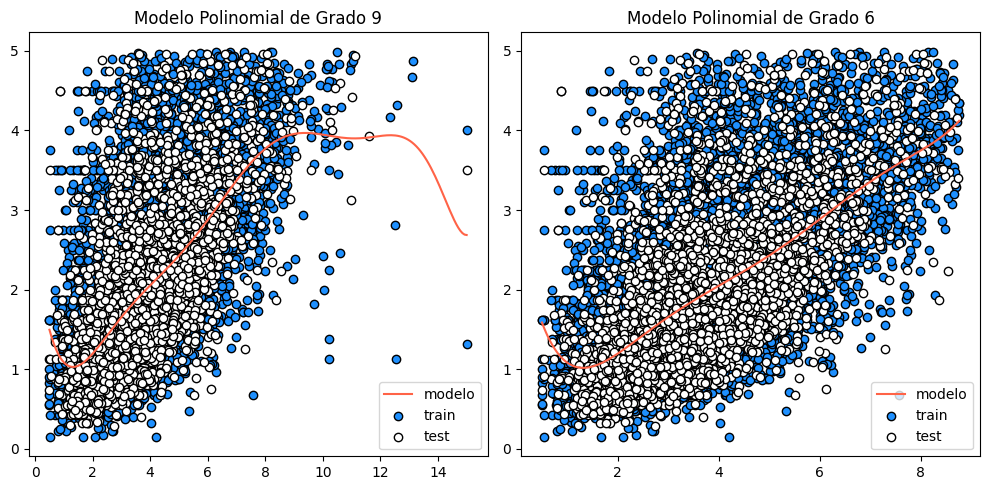

In [189]:
# 4. Reconstruir mejor modelo acá y graficar.
best_degree = degrees[np.argmin(dif_errors)] #Defino el mejor a partir de la resta de los dos errores
best_model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
best_model.fit(X_train_f, y_train)

best_degreec = degrees[np.argmin(dif_errorsc)]
best_modelc = make_pipeline(PolynomialFeatures(best_degreec), LinearRegression())
best_modelc.fit(X_train_fc, y_trainc)

x = np.linspace(x_start, x_end, 200).reshape(-1, 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x, best_model.predict(x), color="tomato", label="modelo")
ax1.scatter(X_train_f, y_train, facecolor="dodgerblue", edgecolor="k", label="train")
ax1.scatter(X_test_f, y_test, facecolor="white", edgecolor="k", label="test")
ax1.set_title(f'Modelo Polinomial de Grado {best_degree}')
ax1.legend()
#Ahora plot sin outliers
ax2.plot(xc, best_modelc.predict(xc), color="tomato", label="modelo")
ax2.scatter(X_train_fc, y_trainc, facecolor="dodgerblue", edgecolor="k", label="train")
ax2.scatter(X_test_c, y_testc, facecolor="white", edgecolor="k", label="test")
ax2.set_title(f'Modelo Polinomial de Grado {best_degreec}')
ax2.legend()
plt.tight_layout()
plt.show()


**Interpretación**

A medida que aumenta el grado del polinomio, el error en el conjunto de entrenamiento disminuye, pero el error en el conjunto de validación puede aumentar después de un cierto punto, indicando sobreajuste. El modelo óptimo es aquel con el grado de polinomio que minimiza la diferencia de errores entre ambos conjuntos. En nuestro caso:

In [190]:
print("Mejor grado de polinomio con outliers",best_degree)
print("Mejor grado de polinomio sin outliers",best_degreec)

Mejor grado de polinomio con outliers 9
Mejor grado de polinomio sin outliers 6


**CONSULTA**

El orden del polinomio que elige cambia al trabajar sin outliers. Pero tambien es dependiendte de la semilla utilizada para entrenar. ¿Cómo se busca lo mas estable?

## Ejercicio 5: Regresión con más de un Atributo

En este ejercicio deben entrenar regresiones que toman más de un atributo de entrada.

1. Seleccione **dos o tres atributos** entre los más relevantes encontrados en el ejercicio 2.
2. Repita el ejercicio anterior, pero usando los atributos seleccionados. No hace falta graficar el modelo final.
3. Interprete el resultado y compare con los ejercicios anteriores. ¿Se obtuvieron mejores modelos? ¿Porqué?

In [191]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]

train_mse2a = []
test_mse2a = []

selector = (np.array(california['feature_names']) == 'MedInc') | (np.array(california['feature_names']) == 'Latitude')

X_train_fs = X_train[:, selector]
X_test_fs = X_test[:, selector]

for degree in degrees:

    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_fs, y_train)

# Predicción y evaluación
    y_train_pred = model.predict(X_train_fs)
    y_test_pred = model.predict(X_test_fs)

# Cálculo del error cuadrático medio
    train_mse2a.append(mean_squared_error(y_train, y_train_pred))
    test_mse2a.append(mean_squared_error(y_test, y_test_pred))

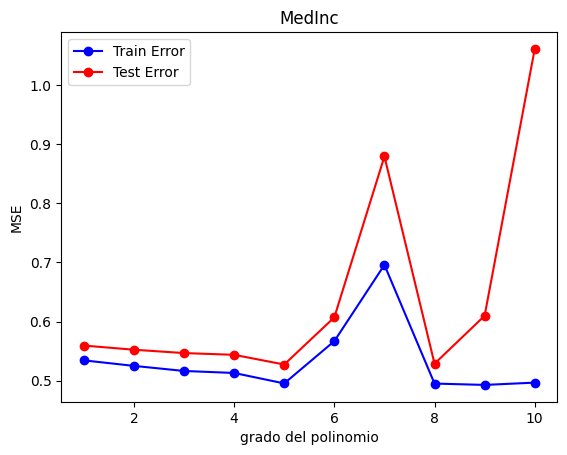

In [192]:
# 2. Graficar curvas de error acá.

# Gráfico de errores
plt.plot(degrees, train_mse2a, color="blue", label="Train Error", marker='o')
plt.plot(degrees, test_mse2a, color="red", label="Test Error", marker='o')
plt.title(feature)
plt.legend()
plt.xlabel('grado del polinomio')
plt.ylabel('MSE')

plt.show()


In [193]:
arr1 = np.array(train_mse2a)
arr2 = np.array(test_mse2a)
dif_errors = abs(arr1 - arr2)
for j in range(len(dif_errors)):
  print("diferencia de errores con outliers",dif_errors[j])
print("menor diferencia entre errores con outliers",dif_errors.min())

diferencia de errores con outliers 0.02499657823618584
diferencia de errores con outliers 0.02730376126651557
diferencia de errores con outliers 0.030229289705170137
diferencia de errores con outliers 0.03066805318157062
diferencia de errores con outliers 0.031956310078473604
diferencia de errores con outliers 0.040258956195419304
diferencia de errores con outliers 0.18329471311224865
diferencia de errores con outliers 0.03354493788352558
diferencia de errores con outliers 0.11691716442492317
diferencia de errores con outliers 0.5639121356486765
menor diferencia entre errores con outliers 0.02499657823618584


La diferencia entre los errores de entrenamiento y validación no disminuyó, de hecho aumentó levemente (esto de todas maneras depende de la corrida por la aleatoriedad de la selección los conjuntos). Tal vez para hacer una comparación precisa se debría fijar la semilla. Sin embargo en esta corrida se logró la minima diferencia con un polinomio de grado mucho menor, implicando que el modelo optimo es un polinomio mas simple.

**Pregunta**

Esto último (lo del grado del polinomio) se podría considerar como una mejoría del modelo?

## Más ejercicios (opcionales)

### Ejercicio 6: A Todo Feature

Entrene y evalúe regresiones pero utilizando todos los atributos de entrada (va a andar mucho más lento). Estudie los resultados.

### Ejercicio 7: Regularización

Entrene y evalúe regresiones con regularización "ridge". Deberá probar distintos valores de "alpha" (fuerza de la regularización). ¿Mejoran los resultados?


In [194]:
#Ejercicio 6

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Utilizando todos los atributos
X_train_all = X_train
X_test_all = X_test

# Instanciación y entrenamiento del modelo
model_all = LinearRegression()
model_all.fit(X_train_all, y_train)

# Predicción y evaluación
y_train_pred_all = model_all.predict(X_train_all)
y_test_pred_all = model_all.predict(X_test_all)

# Cálculo del error cuadrático medio
train_mse_all = mean_squared_error(y_train, y_train_pred_all)
test_mse_all = mean_squared_error(y_test, y_test_pred_all)

print(f'MSE en entrenamiento (todos los atributos): {train_mse_all}')
print(f'MSE en prueba (todos los atributos): {test_mse_all}')


MSE en entrenamiento (todos los atributos): 0.3965477818746124
MSE en prueba (todos los atributos): 0.42681683250938496


#Ejercicio 7

Vamos a implementar la penalización, que será alpha, para distintos grados de polinomio. De esta manera podremos calcular la diferencia de MSE entre entrenamiento y validacion para cada alpha para cada grado de polinomio. Por lo que esta diferencia podrá ser guardada en una matriz donde cada fila corresponde a un grado de polinomio y cada columna a un alpha de modo de poder ver que ridge es conveniente para cada grado de polinomio.

Entrenaremos solo con un atributo: Med Inc

In [195]:
#Ejercicio 7
from sklearn.linear_model import Ridge
# Definir los grados de los polinomios y los valores de alpha
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
alphas = [0.1, 1.0, 10.0, 100.0]

# Inicializar matrices de MSE para entrenamiento y prueba
train_mse_ridge = np.zeros((len(degrees), len(alphas)))
test_mse_ridge = np.zeros((len(degrees), len(alphas)))

# Iterar sobre los valores de alpha
for j, alpha_n in enumerate(alphas):
    # Iterar sobre los grados de los polinomios
    for i, degree in enumerate(degrees):
        # Crear y entrenar el modelo
        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_n))
        model.fit(X_train_fc, y_trainc)

        # Realizar predicciones
        y_train_pred_ridge = model.predict(X_train_fc)
        y_test_pred_ridge = model.predict(X_test_c)

        # Calcular el error cuadrático medio (MSE) y almacenarlo en las matrices
        train_mse_ridge[i, j] = mean_squared_error(y_trainc, y_train_pred_ridge)
        test_mse_ridge[i, j] = mean_squared_error(y_testc, y_test_pred_ridge)

# Imprimir las matrices de MSE
print("Train MSE Ridge:")
print(train_mse_ridge)
print("\nTest MSE Ridge:")
print(test_mse_ridge)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.15006e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.08376e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01821e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.86825e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

Train MSE Ridge:
[[0.53754333 0.53754333 0.53754336 0.53754633]
 [0.53694164 0.53694165 0.53694203 0.53697668]
 [0.53676043 0.53676045 0.53676181 0.5368256 ]
 [0.53627316 0.53627337 0.53628506 0.53637178]
 [0.53496539 0.53501215 0.53565854 0.53632271]
 [0.53451074 0.53486409 0.53561358 0.53582445]
 [0.53437586 0.53440154 0.5345437  0.53542595]
 [0.53428008 0.53432111 0.53463044 0.53496914]
 [0.534232   0.53423686 0.53426217 0.53459229]
 [0.5342055  0.53423131 0.53427948 0.53443649]]

Test MSE Ridge:
[[0.56723079 0.567231   0.56723316 0.56725732]
 [0.56669191 0.56669218 0.56669525 0.56675435]
 [0.56663897 0.56664013 0.56665237 0.5667866 ]
 [0.56689998 0.56688581 0.56679287 0.5666519 ]
 [0.56269126 0.56310942 0.5649414  0.56639288]
 [0.56225389 0.56305418 0.564216   0.56462966]
 [0.56238243 0.56255207 0.56297045 0.56433757]
 [0.56208281 0.5622897  0.56317652 0.56384512]
 [0.56220739 0.56229033 0.56248253 0.56324096]
 [0.56237205 0.56237197 0.56271316 0.56334002]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24023e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24874e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Calculamos la diferencia entre las matrices e imprimimos para cada grado, el mejor alpha

In [196]:
# Calcular la diferencia absoluta entre train_mse_ridge y test_mse_ridge
diff_abs = np.abs(train_mse_ridge - test_mse_ridge)

# Encontrar el índice del mínimo valor de diferencia absoluta para cada grado de polinomio
best_alpha_indices = np.argmin(diff_abs, axis=1)
best_alphas = [alphas[idx] for idx in best_alpha_indices]
min_diffs = np.min(diff_abs, axis=1)

# Imprimir los mejores valores de alpha y la diferencia para cada grado de polinomio
for i, degree in enumerate(degrees):
    print(f"Grado {degree}: Mejor alpha = {best_alphas[i]}, Diferencia MSE Train-Test = {min_diffs[i]}")

Grado 1: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.029687453239389594
Grado 2: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.02975026398699543
Grado 3: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.02987853992555256
Grado 4: Mejor alpha = 100.0, Diferencia MSE Train-Test = 0.0302801159611068
Grado 5: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.027725869245974866
Grado 6: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.027743150219307622
Grado 7: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.028006565452152743
Grado 8: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.027802731878516118
Grado 9: Mejor alpha = 0.1, Diferencia MSE Train-Test = 0.02797538441626901
Grado 10: Mejor alpha = 1.0, Diferencia MSE Train-Test = 0.028140659255658673


Se ve que en ningun caso se obtiene una diferencia de MSE menor que antes.

**Pregunta:** Esto se debe a que no estamos priorizando esto sino que no haya coeficientes tan grandes?

Por último graficamos la diferencia de los MSE (entre train y test) en función del grado del polinomio para cada valor de alpha

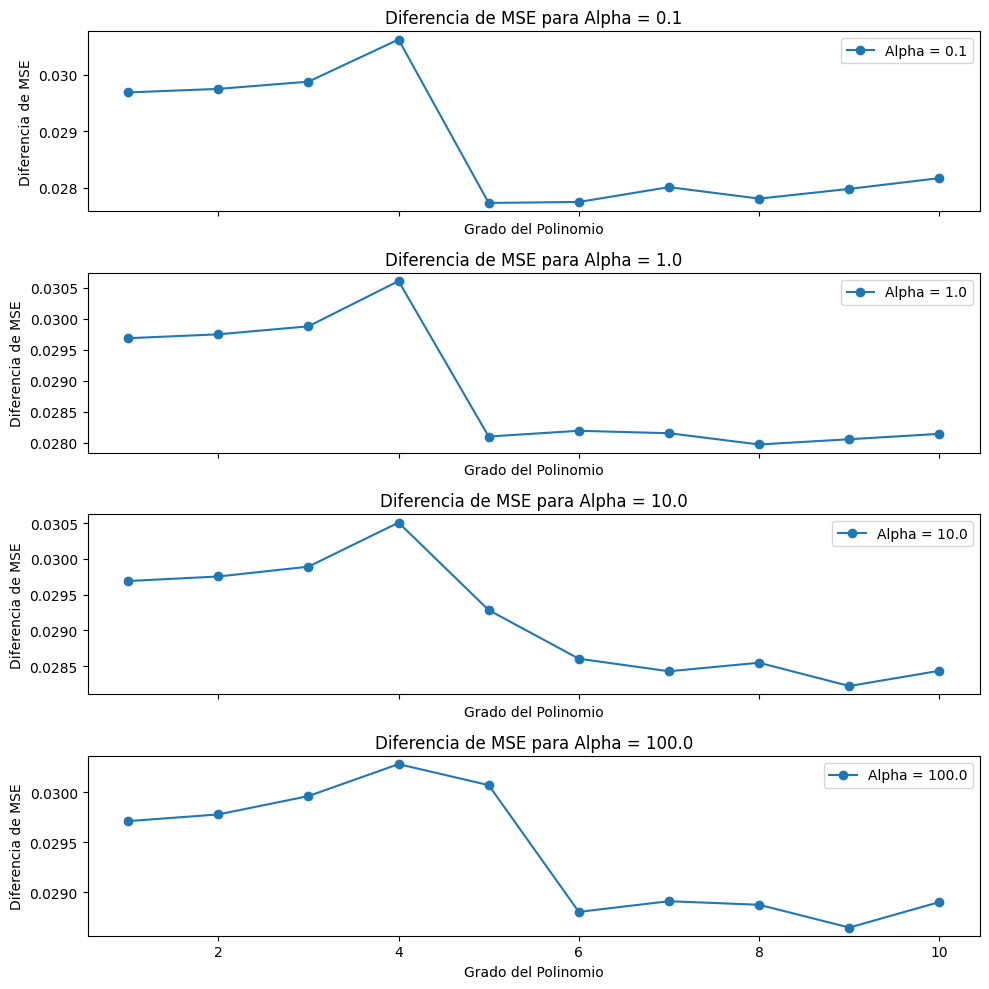

In [197]:
import matplotlib.pyplot as plt

# Configurar el gráfico
fig, axs = plt.subplots(len(alphas), 1, figsize=(10, 10), sharex=True)

# Iterar sobre los valores de alpha para graficar
for j, alpha_n in enumerate(alphas):
    # Graficar diferencia de MSE para el alpha actual
    axs[j].plot(degrees, mse_difference[:, j], label=f'Alpha = {alpha_n}', marker='o')
    axs[j].set_title(f'Diferencia de MSE para Alpha = {alpha_n}')
    axs[j].set_xlabel('Grado del Polinomio')
    axs[j].set_ylabel('Diferencia de MSE')
    axs[j].legend()

plt.tight_layout()
plt.show()